# I'm Somewhat of a Painter Myself

This project explores how deep learning can be used to turn ordinary landscape photos into Monet-style paintings using a CycleGAN model.

#### Dataset Description

The dataset comes from the [GANs Getting Started](https://www.kaggle.com/competitions/gan-getting-started/data) competition on Kaggle. It contains:

- **Monet Paintings**: 300 JPEG images of Claude Monet's impressionist landscape paintings.
- **Real Photos**: 7038 landscape photographs with similar scenery.

The data is provided in jpeg and `.tfrec` (TFRecord) format, which is optimized for use with TensorFlow.

#### Project Goal

The goal is to train a **CycleGAN** (Cycle-Consistent Generative Adversarial Network) to perform unpaired image-to-image translation — specifically, turning real landscape photos into images that resemble Monet’s painting style.

#### Why This Project?

As someone who enjoys painting, this project is especially exciting — it brings together creativity and deep learning. Throughout the notebook, I will:

- Load and visualize the datasets
- Preprocess the images
- Build and train the CycleGAN model
- Visualize training progress and outputs

This project is a great example of how art and AI can intersect in a meaningful way.


In [1]:
!pip install -q git+https://github.com/tensorflow/addons.git
import tensorflow_addons as tfa
print("TFA version:", tfa.__version__)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


2025-07-03 05:45:40.651728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751521541.095550      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751521541.198776      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TFA version: 0.23.0-dev


/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.18.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

In [2]:
# usual imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import shutil
import tensorflow as tf
import tensorflow_addons as tfa

from os import listdir
from os.path import isfile, join
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# some initial parameters
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
autotune = tf.data.AUTOTUNE

### Data Loading

For this project, I worked with two versions of the dataset: one with `.jpg` image files and another with `.tfrec` TFRecord files. Each required a slightly different loading process.

---

#### 1. Loading `.jpg` Image Files

I started with the raw `.jpg` images, which were organized in folders for Monet and Photo images. I used TensorFlow’s built-in `image_dataset_from_directory` method to load them. This handled resizing the images to 256×256 and batching them. Since I didn't need labels, I set it up to return just the image tensors. Normalization was done later during preprocessing.

---

#### 2. Loading `.tfrec` TFRecord Files

Later, I switched to using the TFRecord version of the dataset for better performance. Loading these required writing a custom parsing function to decode each image from the serialized format. I made sure to resize the images to 256×256 and normalize them to the [-1, 1] range while parsing. I also added batching and prefetching to make the pipeline more efficient for training.

---

Both loading methods gave me clean, ready-to-use datasets of 256×256 RGB images for training the models.


In [4]:
# directories
monet_dir = '/kaggle/input/gan-getting-started/monet_jpg'
photo_dir = '/kaggle/input/gan-getting-started/photo_jpg'

In [5]:
monet_filenames = [join(monet_dir, f) for f in listdir(monet_dir) if isfile(join(monet_dir, f))]
photo_filenames = [join(photo_dir, f) for f in listdir(photo_dir) if isfile(join(photo_dir, f))]


In [6]:
# convert to np.arrays
monet_files = [np.array(Image.open(f)) for f in monet_filenames]
photo_files = [np.array(Image.open(f)) for f in photo_filenames]

In [7]:
# retrieving tfrec
monet_tfrec = tf.io.gfile.glob(str('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec'))
photo_tfrec = tf.io.gfile.glob(str('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec'))

In [8]:
# image size
IMAGE_SIZE = [256, 256]

# allows to decode an image
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

# read teh tfrec file format
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [9]:
# load all tfrec
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset

In [10]:
# load tfrec datasets
monet_ds = load_dataset(monet_tfrec, labeled=True).batch(1)
photo_ds = load_dataset(photo_tfrec, labeled=True).batch(1)

I0000 00:00:1751521626.938247      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751521626.938971      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## Exploratory Data Analysis

I started with a basic overview of the dataset — printed out the shape, size, and a few sample entries to get familiar with the structure.

Then I visualized some sample images from both domains: real photos and Monet paintings. I used both the TFRecord and JPEG formats to make sure the data looks as expected and to get an early sense of the visual differences.

Lastly, I computed the mean color distribution for each domain. This gave a quick look at the overall color palettes, which helps in understanding the stylistic gap between real-world images and Monet’s artistic style.


In [11]:
print(f'The size of Photos File is: {len(photo_files)}')
print(f'The size of Monet File is: {len(monet_files)}')
print(f'Shape is: {photo_files[1].shape}')


The size of Photos File is: 7038
The size of Monet File is: 300
Shape is: (256, 256, 3)


In [12]:
# show number of files
print('Monet TFRecord Files:', len(monet_tfrec))
print('Photo TFRecord Files:', len(photo_tfrec))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


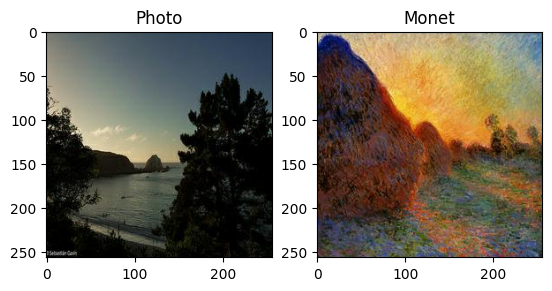

In [13]:
# let's print some examples from jpeg files
plt.subplot(121)
plt.title('Photo')
plt.imshow(mpimg.imread(photo_filenames[42]))

plt.subplot(122)
plt.title('Monet')
plt.imshow(mpimg.imread(monet_filenames[42]))

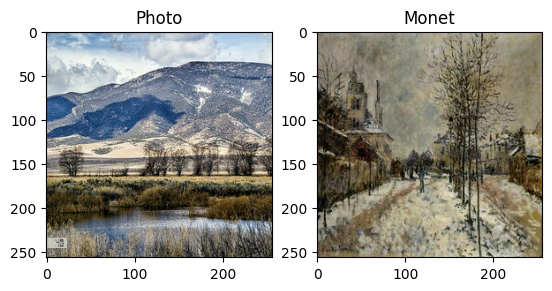

In [14]:
# retrieve an example of each from tfrec files and print them 
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

Text(0.5, 1.0, 'Monet')

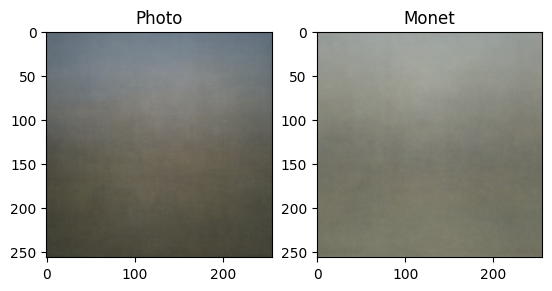

In [15]:
#Mean picure of both real photo and monet
photo_avg=np.mean(photo_files[:300],axis=0).astype(np.uint8)
monet_avg=np.mean(monet_files[:300],axis=0).astype(np.uint8)

plt.subplot(121)
plt.imshow(photo_avg)
plt.title('Photo')

plt.subplot(122)
plt.imshow(monet_avg)
plt.title('Monet')

To get a high-level visual summary of each domain, I computed the mean image for the first 300 samples from both the real photos and Monet paintings. This gives a rough average of the overall color and composition in each set.

The idea is to capture the "essence" of each domain — while individual details are lost, we can still see general trends in color, brightness, and tone. As expected, the Monet average is more stylized and pastel-toned, while the photo average retains more naturalistic color patterns.


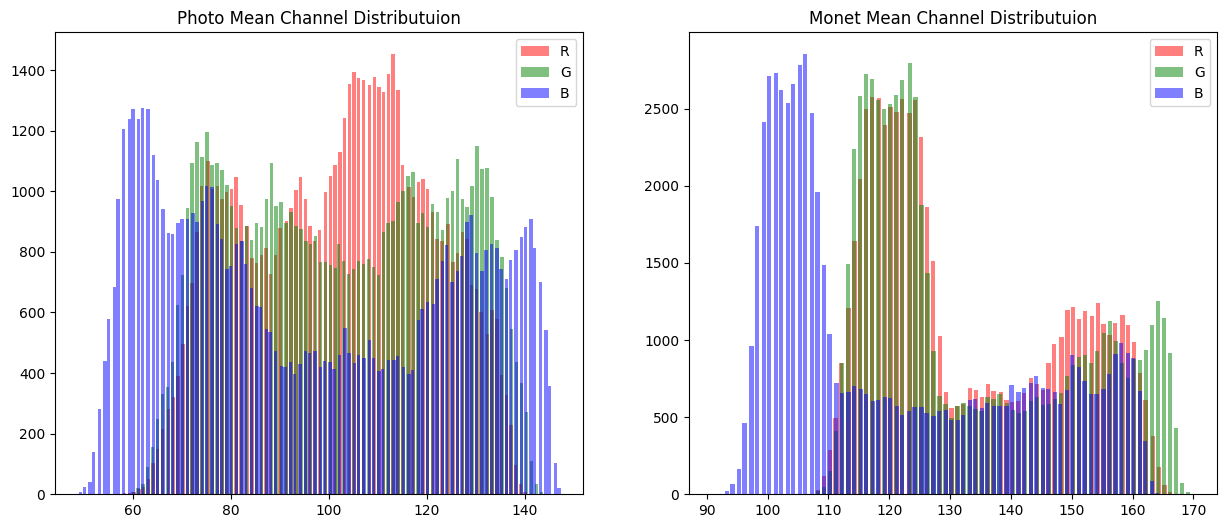

In [16]:
#Mean color Distribution
photo_mean=np.mean(photo_files[:300],axis=0).astype(np.uint8)
monet_mean=np.mean(monet_files[:300],axis=0).astype(np.uint8)
colors=['r','g','b']

plt.figure(figsize=(15,6))

plt.subplot(121)
for i,c in enumerate(colors):
     plt.hist(photo_mean[...,i].ravel(), bins=256, color=c, alpha=0.5,label=c.upper(), width=0.7 )
plt.title('Photo Mean Channel Distributuion')
plt.legend()


plt.subplot(122)
for i,c in enumerate(colors):
     plt.hist(monet_mean[...,i].ravel(), bins=256, color=c, alpha=0.5,label=c.upper(),width=0.7)
plt.title('Monet Mean Channel Distributuion')
plt.legend()



To dig a bit deeper into the visual characteristics of each domain, I computed the mean image for the first 300 samples in both the photo and Monet sets, then plotted the pixel-wise color channel distributions (R, G, B).

These histograms give an idea of how color is used differently across the two domains. Real photos show a more balanced and broader distribution across channels, while Monet paintings tend to lean toward softer, stylized color ranges — often with a more limited or pastel palette.

This kind of analysis can be useful for understanding what kind of color shifts or transformations a model might need to learn during training.


### 3. Model Architecture

CycleGAN is built on two main components: **Generators** and **Discriminators**, forming a symmetric structure that enables image-to-image translation without paired training examples. The model learns to map images from one domain (e.g. real photos) to another (e.g. Monet paintings) and vice versa, while ensuring the mapping is consistent and realistic.

#### 3.1 Build the Generator

The generator is a convolutional neural network that transforms images from one domain to another. It uses:
- **Downsampling layers** to reduce the spatial dimensions and extract high-level features.
- **Residual blocks** to preserve spatial structure while allowing deep feature learning.
- **Upsampling layers** to reconstruct the output image at the original resolution.

This structure allows the generator to perform complex transformations while retaining important visual information.

#### 3.2 Build the Discriminator

The discriminator is another convolutional network, tasked with distinguishing real images from generated ones. Instead of classifying the whole image as real or fake, it operates on patches (*PatchGAN*), which helps the model focus on local texture and style.

Each domain has its own discriminator:
- One to differentiate real photos from generated Monet-style images.
- Another to differentiate real Monet paintings from generated photo-style images.

#### 3.3 Loss Functions and Optimization

CycleGAN uses a combination of losses:
- **Adversarial Loss**: Encourages the generators to produce outputs indistinguishable from real images in the target domain.
- **Cycle Consistency Loss**: Ensures that translating an image to the other domain and back yields the original image (i.e., `X → Y → X` and `Y → X → Y`).
- **Identity Loss** (optional): Helps preserve color and other low-level features when the input already looks like the target domain.

We use **Adam optimizers** for both the generators and discriminators with recommended hyperparameters (e.g., learning rate = 2e-4, beta1 = 0.5).

#### 3.4 CycleGAN Training

The model was trained for **20 epochs**, alternating updates between:
- The generators (to fool the discriminators and maintain cycle consistency).
- The discriminators (to correctly classify real vs. generated images).

Training involves looping through both domains and updating all components iteratively. Over time, the generators learn to produce increasingly realistic translations, and the discriminators get better at judging image authenticity.

This setup allows us to learn high-quality style transfer even without paired examples, which is especially useful in tasks like translating photos to Monet-style paintings.


In [17]:
# number of channel
OUTPUT_CHANNELS = 3

# function to reduce the image size
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [18]:
# function to augment the image size
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Building Generator

In [19]:
# function to generate new image
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

Building Discriminator

In [20]:
#Now, we can create the discriminator.

# function to determine if an image is real or fake
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [21]:
# instance both generators and discriminators
monet_generator = Generator()
photo_generator = Generator()

monet_discriminator = Discriminator()
photo_discriminator = Discriminator()

:Build the CycleGAN Model

We subclassed a `tf.keras.Model` so that we can later use the `fit()` method to train the CycleGAN end-to-end. 

During each training step, the model first translates a real photo into a Monet-style image, and then tries to reconstruct the original photo from that generated Monet image. The difference between the original and the reconstructed photo is captured by the **cycle-consistency loss** — which encourages the model to preserve content and structure through the round-trip transformation.

This ensures that even though we're translating styles, we’re not losing the essence of the original image.

The specific loss functions used to train the model are defined in the following section.


In [22]:
# main class to link generators and discriminator into a trainable solution
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

Loss Functions:

To monitor the training progress and guide the model's updates, we calculate several losses at each step:

- **Generator Loss**: Measures how well the generator fools the discriminator into thinking the generated image is real. The goal is to generate images indistinguishable from the target domain.

- **Discriminator Loss**: Evaluates how well the discriminator distinguishes real images from generated ones. The discriminator tries to correctly classify real vs. fake, while the generator tries to fool it.

- **Cycle Consistency Loss**: Ensures that translating an image to the other domain and back reconstructs the original. This is critical for unpaired image translation, as it preserves structure and content.

- **Identity Loss**: Encourages the generator to preserve image content when the input already looks like the target domain. This helps retain color and low-level details.

Together, these losses ensure the model not only generates realistic-looking images, but also maintains consistency and structure across translations.


In [23]:
# loss function for the discriminator
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5
    
# loss function for the generator
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

# loss for the cycle consistency
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

# loss for the identity
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

Train the CycleGAN:

To train the full CycleGAN architecture, we need four separate optimizers — one for each of the two generators and two discriminators.

We use the **Adam optimizer** with a learning rate of `1e-4` and `beta_1 = 0.5`, which is a common setting for GANs. This helps stabilize training by smoothing the gradients and preventing sudden jumps during updates.

The optimizers are defined as follows:

- `monet_generator_optimizer` — updates the generator that translates photos to Monet-style images.
- `photo_generator_optimizer` — updates the generator that translates Monet-style images back to photo-realistic ones.
- `monet_discriminator_optimizer` — updates the discriminator for distinguishing real vs. generated Monet paintings.
- `photo_discriminator_optimizer` — updates the discriminator for distinguishing real vs. generated photos.

With these optimizers in place, the model can be trained end-to-end using custom training loops or the `fit()` API, depending on how the `CycleGAN` class is implemented.


In [24]:
# instance all necessary optimizer
monet_generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
# instance the model
cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

# compile the model
cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

Training


In [25]:
# train the model
history=cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=20
)

Epoch 1/20


I0000 00:00:1751521700.494330     219 service.cc:148] XLA service 0x7fca00003d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751521700.496445     219 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751521700.496463     219 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751521707.466704     219 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1751521717.132371     219 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751521717.386195     219 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751521719.236722     219 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

300/300 ━━━━━━━━━━━━━━━━━━━━ 168s 207ms/step - monet_disc_loss: 0.5900 - monet_gen_loss: 6.1129 - photo_disc_loss: 0.5660 - photo_gen_loss: 6.2783
Epoch 2/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 220ms/step - monet_disc_loss: 0.6507 - monet_gen_loss: 3.9996 - photo_disc_loss: 0.5194 - photo_gen_loss: 4.2350
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 219ms/step - monet_disc_loss: 0.6284 - monet_gen_loss: 3.8051 - photo_disc_loss: 0.4840 - photo_gen_loss: 4.1610
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 219ms/step - monet_disc_loss: 0.6058 - monet_gen_loss: 3.8190 - photo_disc_loss: 0.4237 - photo_gen_loss: 4.2975
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 219ms/step - monet_disc_loss: 0.5795 - monet_gen_loss: 3.7932 - photo_disc_loss: 0.5234 - photo_gen_loss: 4.1036
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 219ms/step - monet_disc_loss: 0.5565 - monet_gen_loss: 3.7905 - photo_disc_loss: 0.5709 - photo_gen_loss: 3.9211
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 219ms/step - monet_disc_loss: 0.5785 - monet_gen_loss: 3.7198 - photo_disc_loss: 0.5847 - photo_gen_loss: 3.8326
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 65s 218ms/step - monet_disc_l

### Visualize our Monet-esque pictures

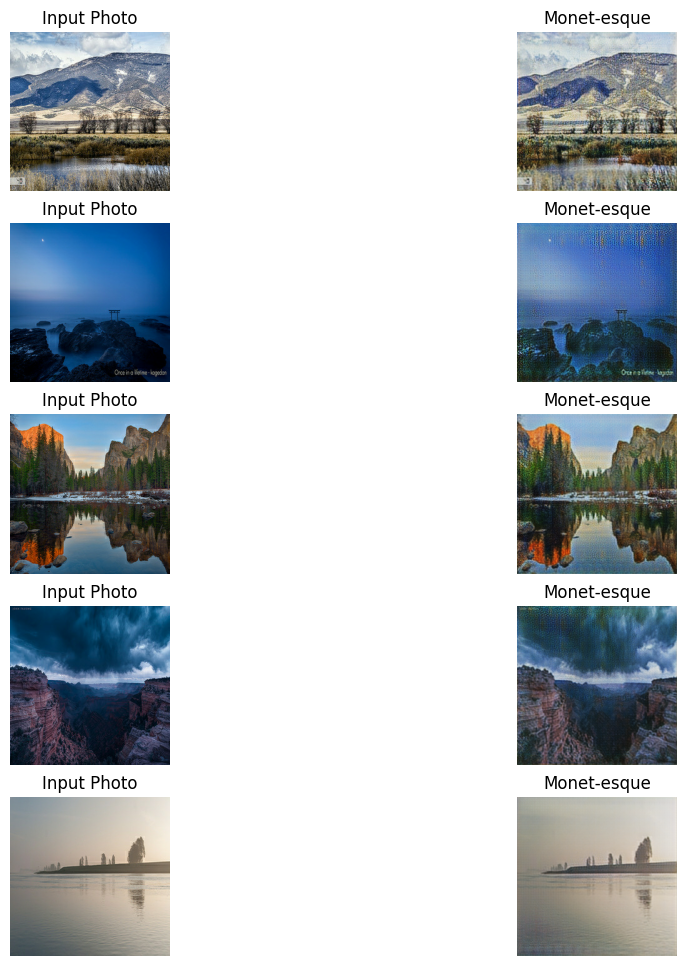

In [28]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

Submission:

In [26]:
import zipfile
import io
from PIL import Image
import numpy as np

zip_path = "/kaggle/working/images.zip"

# Step 1: Open zipfile in write mode
with zipfile.ZipFile(zip_path, 'w') as zipf:
    i = 1
    for img in photo_ds:
        # Step 2: Generate prediction
        prediction = monet_generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        im = Image.fromarray(prediction)

        # Step 3: Save image to a buffer (in memory)
        buffer = io.BytesIO()
        im.save(buffer, format="JPEG")
        buffer.seek(0)

        # Step 4: Write the buffer to the zip file
        zipf.writestr(f"{i}.jpg", buffer.read())
        i += 1
        if i>7000:
            break


### Conclusion

CycleGAN is a fairly complex architecture that requires careful tuning to get the best possible results. That said, it’s impressive how quickly the model starts producing decent outputs — often within just a few epochs.

To improve performance further, a few strategies could be considered:

- Adding more layers to the generators and discriminators to help them better capture the unique characteristics of each domain.
- Training for more epochs to allow the model to refine its outputs and learn more nuanced patterns.
- Experimenting with different image preprocessing techniques to help the model converge faster and more effectively.
